In [2]:
import cv2
import numpy as np
import utils
from numpy.linalg import svd, inv
import os
import glob
from tqdm import tqdm
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.patches as patches


In [3]:
def computeHomography(pts1, pts2):
    '''
    Compute homography that maps from pts1 to pts2 using least squares solver
     
    Input: pts1 and pts2 are 3xN matrices for N points in homogeneous
    coordinates. 
    
    Output: H is a 3x3 matrix, such that pts2~=H*pts1
    '''
    (_, n) = pts1.shape
    A = np.zeros((2*n, 9))
    
    for i in range(n):       
        u = pts1[:,i][0]/pts1[:,i][2]
        v = pts1[:,i][1]/pts1[:,i][2]
        u_ = pts2[:,i][0]/pts2[:,i][2]
        v_ = pts2[:,i][1]/pts2[:,i][2]
        A[i*2,:] = [-u,-v,-1,0,0,0,u*u_, v*u_, u_] 
        A[i*2+1,:] = [0,0,0,-u,-v,-1,u*v_, v*v_, v_]
    u, s, vh = np.linalg.svd(A)
    H = vh.T[:, -1]
    H /= H[-1]
    
    
    return H.reshape((3,3))

So a least-squares solution minimizes the sum of the squares of the differences between the entries of A K x and b . In other words, a least-squares solution solves the equation Ax = b as closely as possible

In [4]:
def auto_homography(Ia,Ib, homography_func=None, normalization_func=None):
    '''
    Computes a homography that maps points from Ia to Ib

    Input: Ia and Ib are images
    Output: H is the homography

    '''
    if Ia.dtype == 'float32' and Ib.dtype == 'float32':
        Ia = (Ia*255).astype(np.uint8)
        Ib = (Ib*255).astype(np.uint8)
    
    Ia_gray = cv2.cvtColor(Ia,cv2.COLOR_BGR2GRAY)
    Ib_gray = cv2.cvtColor(Ib,cv2.COLOR_BGR2GRAY)

    # Initiate SIFT detector
    sift = cv2.SIFT_create()
    
    # find the keypoints and descriptors with SIFT
    kp_a, des_a = sift.detectAndCompute(Ia_gray,None)
    kp_b, des_b = sift.detectAndCompute(Ib_gray,None)    
    
    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des_a,des_b, k=2)

    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good.append(m)
   
    numMatches = int(len(good))

    matches = good

    # Xa and Xb are 3xN matrices that contain homogeneous coordinates for the N
    # matching points for each image
    Xa = np.ones((3,numMatches))
    Xb = np.ones((3,numMatches))
    
    for idx, match_i in enumerate(matches):
        Xa[:,idx][0:2] = kp_a[match_i.queryIdx].pt
        Xb[:,idx][0:2] = kp_b[match_i.trainIdx].pt
    ## RANSAC
    niter = 1000
    best_score = 0

    for t in range(niter):
        # estimate homography
        subset = np.random.choice(numMatches, 4, replace=False)
        pts1 = Xa[:,subset]
        pts2 = Xb[:,subset]
        
        H_t = homography_func(pts1, pts2) # edit helper code below (computeHomography)

        # score homography
        Xb_ = np.dot(H_t, Xa) # project points from first image to second using H
        du = Xb_[0,:]/Xb_[2,:] - Xb[0,:]/Xb[2,:]
        dv = Xb_[1,:]/Xb_[2,:] - Xb[1,:]/Xb[2,:]

        ok_t = np.sqrt(du**2 + dv**2) < 3  # you may need to play with this threshold
        score_t = sum(ok_t)

        if score_t > best_score:
            best_score = score_t
            H = H_t
            in_idx = ok_t
    
    #print('best score: {:02f}'.format(best_score))

    # Optionally, you may want to re-estimate H based on inliers

    return H

The scale-invariant feature transform (SIFT) is a computer vision algorithm to detect, describe, and match local features in images
Random sample consensus, or RANSAC, is an iterative method for estimating a mathematical model from a data set that contains outliers. The RANSAC algorithm works by identifying the outliers in a data set and estimating the desired model using data that does not contain outliers.

In [5]:
def computeHomography(pts1, pts2):
    '''
    Compute homography that maps from pts1 to pts2 using least squares solver
     
    Input: pts1 and pts2 are 3xN matrices for N points in homogeneous
    coordinates. 
    
    Output: H is a 3x3 matrix, such that pts2~=H*pts1
    '''
    (_, n) = pts1.shape
    A = np.zeros((2*n, 9), dtype = np.float32)
    
    for i in range(n):       
        u = pts1[:,i][0]/pts1[:,i][2]
        v = pts1[:,i][1]/pts1[:,i][2]
        u_ = pts2[:,i][0]/pts2[:,i][2]
        v_ = pts2[:,i][1]/pts2[:,i][2]
        A[i*2,:] = [-u,-v,-1,0,0,0,u*u_, v*u_, u_] 
        A[i*2+1,:] = [0,0,0,-u,-v,-1,u*v_, v*v_, v_]
    u, s, vh = np.linalg.svd(A)
    H = vh[-1, :]
    H /= H[-1]
    
    
    return H.reshape((3,3))


In [6]:
def naive_blend(im1, im2):
    mask = im2 != 0
    im1 = im1*(1-mask)
    return im1+im2

In [7]:
master_frames =['100','200', '300', '400', '500']
frames = []

frames.append(cv2.imread('background_frames/100.jpg'))
for i in range(1, len(master_frames)):
    frames.append(cv2.imread('background_frames/'+ master_frames[i] +'.jpg'))

H12 = auto_homography(frames[0],frames[1], computeHomography)
H23 = auto_homography(frames[1],frames[2], computeHomography)
H34 = auto_homography(frames[3],frames[2], computeHomography)
H45 = auto_homography(frames[4],frames[3], computeHomography)

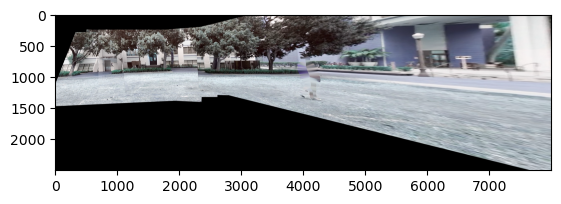

In [8]:
H_t = np.array([[1, 0, 700], [0, 1, 250], [0, 0, 1]])

img_warped = cv2.warpPerspective(frames[0], H_t.dot(H12), (8000, 2500))
img_warped1 = cv2.warpPerspective(frames[1], H_t.dot(H23), (8000, 2500))
img_warped2 = cv2.warpPerspective(frames[3], H_t.dot(H34), (8000, 2500))
img_warped3 = cv2.warpPerspective(frames[4], H_t.dot(H45@H34), (8000, 2500))

blended = naive_blend(img_warped, img_warped1)

blended[250:250+1080, 700:700+1920, :] = frames[2]
blended = naive_blend(blended, img_warped2)
blended = naive_blend(blended, img_warped3)
blended = blended.astype(np.uint8)

plt.imshow(blended)
# cv2.imwrite('panorama_.jpg', blended)

In [9]:
from math import floor

In [69]:
dir_frames = 'background_frames'
filenames = []
filesinfo = os.scandir(dir_frames)

In [70]:
filenames = [f.path for f in filesinfo if f.name.endswith(".jpg")]
filenames.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

In [71]:
frameCount = len(filenames)
frameHeight, frameWidth, frameChannels = cv2.imread(filenames[0]).shape
frames = np.zeros((frameCount, frameHeight, frameWidth, frameChannels),dtype=np.float32)

In [72]:
for idx, file_i in enumerate(filenames):
    frames[idx] = cv2.imread(file_i) / 255.0
    #frames[idx] = cv2.cvtColor(cv2.imread(file_i), cv2.COLOR_BGR2RGB) / 255.0

In [73]:
pastHomographies = np.zeros((len(filenames),len(filenames), 3, 3),dtype=np.float32)
originTranslations = np.zeros((len(filenames), 2), dtype=np.float32)

In [74]:
for i in tqdm(range(100, 300)):
    projectedReference, pastHomographies, originTranslations = utils.projectImage(frames, i, 200,
                                                               pastHomographies, originTranslations,
                                                               auto_H_func=auto_homography, xrange=4000,
                                                               yrange=1500,homography_func=computeHomography, 
                                                               numKeyframes=5)
    cv2.imwrite('aligned_frames0/a{:04d}.jpg'.format(i+1), projectedReference)


100%|████████████████████████████████████████████████████████████████████| 200/200 [20:11<00:00,  6.06s/it]


For those frames that have small or no overlap with the reference frame you need to first map them onto the closest key frame. You can produce a direct homography between each frame and the reference frame by multiplying the two projection matrices. 

In [75]:
dir_frames = 'aligned_frames0'
filenames = []
filesinfo = os.scandir(dir_frames)

In [76]:
filenames = [f.path for f in filesinfo if f.name.endswith(".jpg")]
filenames.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

In [77]:
frameCount = len(filenames)
projected_frames = np.zeros((frameCount, 1500, 4000, frameChannels),dtype=np.float32)

In [78]:
for idx, file_i in enumerate(filenames):
    projected_frames[idx] = cv2.imread(file_i) / 255.0

In [79]:
background = np.zeros((1500, 4000, 3))

In [80]:
for i in tqdm(range(1500)):
    for j in range(4000):
        for c in range(3):
            nonzero = np.nonzero(projected_frames[:, i, j, c])
            if len(nonzero) != 0:
                #print(np.median(projected_frames[nonzero, i, j, c]))
                background[i][j][c] = np.median(projected_frames[nonzero, i, j, c])


100%|██████████████████████████████████████████████████████████████████| 1500/1500 [07:54<00:00,  3.16it/s]


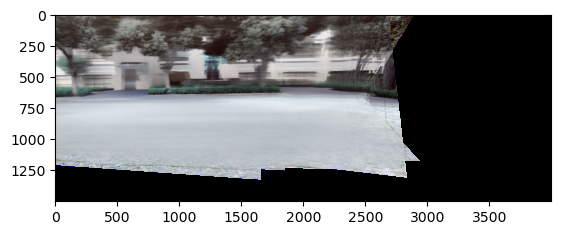

In [81]:
plt.imshow(background)

In [82]:
cv2.imwrite('background_panorama.jpg', background*255)

True

In [83]:
x_min, y_min = originTranslations[0]
t = [-x_min, -y_min]
H_t = np.array([[1, 0, t[0]], [0, 1, t[1]], [0, 0, 1]], dtype=np.float32)

In [90]:
for i in tqdm(range(101, 301)):
    projected_background = cv2.warpPerspective(background, np.linalg.pinv(H_t.dot(pastHomographies[i][200])), (1920, 1080))
    cv2.imwrite('background/a{:04d}.jpg'.format(i+1), projected_background*255)

100%|████████████████████████████████████████████████████████████████████| 200/200 [00:07<00:00, 28.08it/s]


In [92]:
utils.imageFolder2mpeg('background', fps=24)

OpenCV: FFMPEG: tag 0x3147504d/'MPG1' is not supported with codec id 1 and format 'mpeg / MPEG-1 Systems / MPEG program stream'


Map the background panorama to the movie coordinates. For each frame of the movie, say frame 1, you need to estimate a projection from the panorama to frame 1. Note, you should be able to re-use the homographies that you estimated. Perform this for all frames and generate a movie that looks like the input movie but shows only background pixels. All moving objects that belong to the foreground must be removed.

In [49]:
import cv2
vidcap = cv2.VideoCapture('test2.mp4')
success,image = vidcap.read()
count = 0
while success:
    f'{count:03d}'
    cv2.imwrite("original/%d.jpg" % count, image)     # save frame as JPEG file      
    success,image = vidcap.read()
    count += 1

In [50]:
dir_frames = 'original'
filenames = []
filesinfo = os.scandir(dir_frames)

In [51]:
filenames = [f.path for f in filesinfo if f.name.endswith(".jpg")]
filenames.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

In [52]:
frameCount = len(filenames)
frameHeight, frameWidth, frameChannels = cv2.imread(filenames[0]).shape
frames = np.zeros((frameCount, frameHeight, frameWidth, frameChannels),dtype=np.float32)

In [53]:
for idx, file_i in enumerate(filenames):
    frames[idx] = cv2.imread(file_i) / 255.0
    #frames[idx] = cv2.cvtColor(cv2.imread(file_i), cv2.COLOR_BGR2RGB) / 255.0

In [54]:
frameCount = len(filenames)
projected_frames = np.zeros((frameCount, 1500, 4000, frameChannels),dtype=np.float32)

In [56]:
pastHomographies = np.zeros((len(filenames),len(filenames), 3, 3),dtype=np.float32)
originTranslations = np.zeros((len(filenames), 2), dtype=np.float32)

In [58]:
for i in tqdm(range(200)):
    projectedReference, pastHomographies, originTranslations = utils.projectImage(frames, i, 100,
                                                               pastHomographies, originTranslations,
                                                               auto_H_func=auto_homography, xrange=4000,
                                                               yrange=1500,homography_func=computeHomography, 
                                                               numKeyframes=5)
    cv2.imwrite('aligned_frames2/{:04d}.jpg'.format(i+1), projectedReference)

 98%|██████████████████████████████████████████████████████████████████▋ | 196/200 [07:51<00:06,  1.65s/it]

Finding better homography...


 98%|██████████████████████████████████████████████████████████████████▉ | 197/200 [08:49<00:55, 18.53s/it]

Found better homography


100%|████████████████████████████████████████████████████████████████████| 200/200 [08:55<00:00,  2.68s/it]


In [60]:
for i in tqdm(range(200, 400)):
    projectedReference, pastHomographies, originTranslations = utils.projectImage(frames, i, 300,
                                                               pastHomographies, originTranslations,
                                                               auto_H_func=auto_homography, xrange=4000,
                                                               yrange=1500,homography_func=computeHomography, 
                                                               numKeyframes=5)
    cv2.imwrite('aligned_frames2/{:04d}.jpg'.format(i+1), projectedReference)

 12%|███████▉                                                             | 23/200 [02:47<12:30,  4.24s/it]

Finding better homography...


 12%|████████▎                                                            | 24/200 [03:21<37:58, 12.95s/it]

Found better homography


 14%|██████████                                                           | 29/200 [03:35<12:49,  4.50s/it]

Finding better homography...


 15%|██████████▎                                                          | 30/200 [04:25<51:11, 18.07s/it]

Found better homography


100%|████████████████████████████████████████████████████████████████████| 200/200 [28:06<00:00,  8.43s/it]


In [62]:
for i in tqdm(range(400, 600)):
    projectedReference, pastHomographies, originTranslations = utils.projectImage(frames, i, 400,
                                                               pastHomographies, originTranslations,
                                                               auto_H_func=auto_homography, xrange=4000,
                                                               yrange=1500,homography_func=computeHomography, 
                                                               numKeyframes=5)
    cv2.imwrite('aligned_frames2/{:04d}.jpg'.format(i+1), projectedReference)

 55%|█████████████████████████████████████                               | 109/200 [07:35<05:08,  3.39s/it]

Finding better homography...


 55%|█████████████████████████████████████▍                              | 110/200 [08:31<28:38, 19.10s/it]

Found better homography


 56%|██████████████████████████████████████                              | 112/200 [08:37<16:02, 10.93s/it]

Finding better homography...


 56%|██████████████████████████████████████▍                             | 113/200 [09:36<36:32, 25.20s/it]

Found better homography
Finding better homography...


 57%|██████████████████████████████████████▊                             | 114/200 [10:34<50:13, 35.04s/it]

Found better homography


 60%|████████████████████████████████████████▍                           | 119/200 [10:47<10:56,  8.11s/it]

Finding better homography...


 60%|████████████████████████████████████████▊                           | 120/200 [11:36<27:11, 20.39s/it]

Found better homography
Finding better homography...


 60%|█████████████████████████████████████████▏                          | 121/200 [11:53<25:09, 19.11s/it]

Found better homography


 61%|█████████████████████████████████████████▍                          | 122/200 [11:55<18:22, 14.14s/it]

Finding better homography...


 62%|█████████████████████████████████████████▊                          | 123/200 [12:41<30:20, 23.64s/it]

Found better homography
Finding better homography...


 62%|██████████████████████████████████████████▏                         | 124/200 [13:24<37:12, 29.38s/it]

Found better homography


 62%|██████████████████████████████████████████▌                         | 125/200 [13:26<26:36, 21.29s/it]

Finding better homography...


 63%|██████████████████████████████████████████▊                         | 126/200 [14:16<36:55, 29.93s/it]

Found better homography
Finding better homography...


 64%|███████████████████████████████████████████▏                        | 127/200 [14:27<29:29, 24.24s/it]

Found better homography


 65%|████████████████████████████████████████████▏                       | 130/200 [14:34<11:22,  9.75s/it]

Finding better homography...


 66%|████████████████████████████████████████████▌                       | 131/200 [15:34<28:42, 24.96s/it]

Found better homography
Finding better homography...


 66%|████████████████████████████████████████████▉                       | 132/200 [16:34<40:02, 35.33s/it]

Found better homography
Finding better homography...


 66%|█████████████████████████████████████████████▏                      | 133/200 [16:39<29:29, 26.41s/it]

Found better homography
Finding better homography...


 67%|█████████████████████████████████████████████▌                      | 134/200 [17:32<37:36, 34.19s/it]

Found better homography


 68%|█████████████████████████████████████████████▉                      | 135/200 [17:33<26:28, 24.44s/it]

Finding better homography...


 68%|██████████████████████████████████████████████▏                     | 136/200 [18:14<31:09, 29.21s/it]

Found better homography


 68%|██████████████████████████████████████████████▌                     | 137/200 [18:16<22:02, 21.00s/it]

Finding better homography...


 69%|██████████████████████████████████████████████▉                     | 138/200 [18:57<27:57, 27.05s/it]

Found better homography
Finding better homography...


 70%|███████████████████████████████████████████████▎                    | 139/200 [19:08<22:35, 22.22s/it]

Found better homography
Finding better homography...


 70%|███████████████████████████████████████████████▌                    | 140/200 [19:49<27:52, 27.88s/it]

Found better homography


 70%|███████████████████████████████████████████████▉                    | 141/200 [19:52<20:01, 20.36s/it]

Finding better homography...


 71%|████████████████████████████████████████████████▎                   | 142/200 [20:31<25:08, 26.02s/it]

Found better homography


 72%|████████████████████████████████████████████████▌                   | 143/200 [20:34<18:05, 19.04s/it]

Finding better homography...


 72%|████████████████████████████████████████████████▉                   | 144/200 [21:13<23:26, 25.12s/it]

Found better homography
Finding better homography...


 72%|█████████████████████████████████████████████████▎                  | 145/200 [21:23<18:54, 20.63s/it]

Found better homography


 73%|█████████████████████████████████████████████████▋                  | 146/200 [21:26<13:50, 15.37s/it]

Finding better homography...


 74%|█████████████████████████████████████████████████▉                  | 147/200 [22:03<19:23, 21.96s/it]

Found better homography


 76%|████████████████████████████████████████████████████                | 153/200 [22:19<03:40,  4.69s/it]

Finding better homography...


 77%|████████████████████████████████████████████████████▎               | 154/200 [22:54<10:43, 14.00s/it]

Found better homography


 78%|█████████████████████████████████████████████████████               | 156/200 [22:59<05:50,  7.96s/it]

Finding better homography...


 78%|█████████████████████████████████████████████████████▍              | 157/200 [23:29<10:26, 14.58s/it]

Found better homography


 79%|█████████████████████████████████████████████████████▋              | 158/200 [23:32<07:46, 11.12s/it]

Finding better homography...


 80%|██████████████████████████████████████████████████████              | 159/200 [24:09<12:53, 18.88s/it]

Found better homography


 84%|████████████████████████████████████████████████████████▊           | 167/200 [24:34<02:11,  3.98s/it]

Finding better homography...


 84%|████████████████████████████████████████████████████████▊           | 167/200 [25:11<04:58,  9.05s/it]


KeyboardInterrupt: 

In [99]:
img_array=[]
filesinfo = os.scandir('aligned_frames2')
filenames = [f.path for f in filesinfo if f.name.endswith(".jpg")]
filenames.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
count = 0
temp2 = 0
for f in filenames:
    count = int(count/10)
    img = cv2.imread(f)
    img = img[count:1080+count, count:1920+count]
    h, w, l = img.shape
    size = (w, h)
    img_array.append(img)
    if temp2 < 350:
        count = count+1
    else:
        count = count+5
out = cv2.VideoWriter('app2.mp4', cv2.VideoWriter_fourcc(*'MP4V'), 23, size)
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
